# Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks, correlate, butter, filtfilt
from sklearn.decomposition import NMF

# Define functions for exercise 1

## Visualization functions

In [17]:
def plot_portion(signal_in, indexes):
    plt.figure()
    plt.plot(signal_in[indexes[0]:indexes[1]])
    plt.show()

def plot_detection_output(signal_in, spike_idx, indexes):
    spike_idx = np.asarray([x for x in spike_idx if x>indexes[0] and x<indexes[1]])
    plt.figure()
    plt.plot(signal_in[indexes[0]:indexes[1]])
    plt.plot(spike_idx-indexes[0], signal_in[spike_idx], 'r.', ms=10)
    plt.show()

def plot_spike_matrix(signal_in, spike_idx, half_length, template=[]):
    spike_matrix = []
    for i in spike_idx[1:-1]:
        spike_matrix.append(signal_in[i-half_length:i+half_length])
    spike_matrix = np.asarray(spike_matrix).transpose().squeeze()
    plt.figure()
    plt.plot(spike_matrix, 'k')
    plt.plot(template, 'r', lw=2)
    plt.show()
    return spike_matrix

## Detection functions

In [18]:
def threshold_detection(signal_in, ths, ref):
    signal_in = signal_in.squeeze()
    pk_locs = find_peaks(signal_in, height=ths, distance=ref)

    return pk_locs[0]


def template_detection(signal_in, template, ths, ref):
    signal_in = signal_in.reshape(-1,1)
    template = template.reshape(-1,1)
    xcorr = correlate(signal_in, template, mode='same').squeeze()
    pk_locs = find_peaks(xcorr, distance=ref, height=ths*np.max(xcorr))

    return pk_locs[0]

## Sorting functions

In [19]:
def template_sorting(spike_matrix, template_matrix):
    distances = []
    for i in spike_matrix.shape[1]:
        distances.append(
            [np.sqrt(np.sum((spike_matrix[:,i] - template_matrix[:,j]))) for j in template_matrix.shape[1]]
        )
    distances = np.asarray(distances)

    return np.argmax(distances, axis=1)

# Analysis for exercise 1

## Import and visualize data

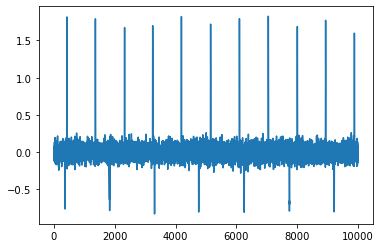

In [20]:
data = pd.read_csv('../signals/nsp4.csv').values

plot_portion(data, (10000,20000))

## Spike detection

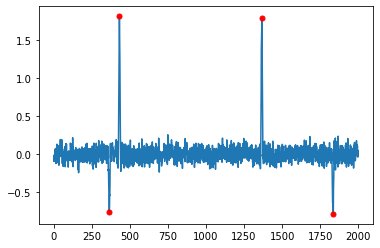

In [21]:
idx_threshold = threshold_detection(np.abs(data), ths=0.6, ref=0.003*1e4)

plot_detection_output(signal_in=data, spike_idx=idx_threshold, indexes=(10000,12000))

## Visualize spike matrix

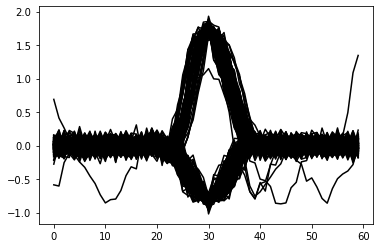

In [22]:
spike_mat = plot_spike_matrix(signal_in=data, spike_idx=idx_threshold, half_length=30)

## Sorting with template

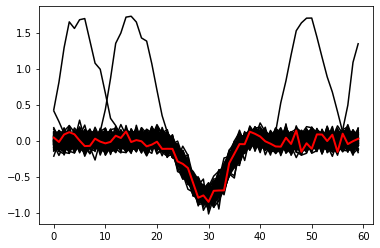

In [23]:
template = spike_mat[:,0].squeeze()
idx_template = template_detection(signal_in=data, template=template, ths=0.6, ref=0.003*1e4)
spike_mat_template = plot_spike_matrix(signal_in=data, spike_idx=idx_template, half_length=30, template=template)

# Define function for exercise 2

## EMG processing functions

In [24]:
def filter_emg(data_in, band_pass, notch_f, fs):
    b,a = butter(
        3,
        [x/fs for x in band_pass],
        btype='bandpass'
    )
    data_out = filtfilt(b, a, data_in, axis=0)
    b,a = butter(
        3,
        [x/fs for x in [notch_f-0.5, notch_f+0.5]],
        btype='bandstop'
    )
    data_out = filtfilt(b, a, data_out, axis=0)

    return data_out

def extract_envelope(data_in, fc, fs):
    b,a = butter(
        3,
        fc/fs,
        btype='lowpass'
    )
    return np.abs(filtfilt(b, a, np.abs(data_in), axis=0))

def normalize_amplitude(data_in):
    data_out = data_in.copy()
    for i in range(data_in.shape[1]):
        data_out[:,i] /= np.mean(data_in[:,i])
    return data_out

## Synergy functions

In [25]:
def VAF(true_data, rec_data):

    return 1 - np.sum((true_data.flatten() - rec_data.flatten())**2)/np.sum(rec_data.flatten()**2)

def extract_synergies(data_in):
    n_muscles = data_in.shape[1]
    nmf_options = {
        'solver': 'mu',
        'max_iter': 2000,
        'init': 'random'
    }
    VAF_tot = []
    VAF_muscles = []
    H_tot = []
    W_tot = []
    for i in range(n_muscles):
        nmf = NMF(n_components=i+1, **nmf_options)
        H_tot.append(nmf.fit_transform(data_in).transpose())
        W_tot.append(nmf.components_.transpose())
        rec = (W_tot[-1]@H_tot[-1]).transpose()
        VAF_tot.append(VAF(data_in, rec))
        VAF_muscles.append( 
            [VAF(data_in[:,k], rec[:,k]) for k in range(n_muscles)] 
        )

    VAF_tot = np.asarray(VAF_tot)
    VAF_muscles = np.asarray(VAF_muscles)
    plt.figure(figsize=(6,12))
    plt.subplot(211)
    plt.plot(np.linspace(1,n_muscles, n_muscles), VAF_tot)
    plt.subplot(212)
    for i in range(n_muscles):
        plt.plot(np.linspace(1,n_muscles, n_muscles), VAF_muscles[:,i])
    plt.show()
    
    return W_tot, H_tot, VAF_tot, VAF_muscles

# Analysis for exercise 2

## Load data

In [26]:
data_emg = pd.read_csv('../signals/reaching1_signal.csv').values

## Prepare data and visualize results

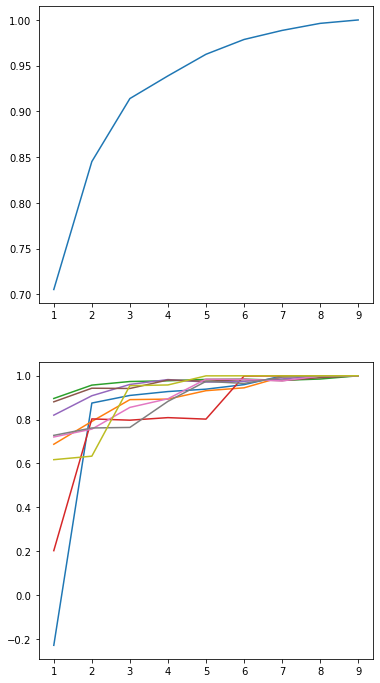

In [27]:
data_filt = filter_emg(data_in=data_emg, band_pass=(25,450), notch_f=50, fs=1000)
env = extract_envelope(data_filt, 15, 1000)
W_tot, H_tot, VAF_tot, VAF_muscles = extract_synergies(data_in=normalize_amplitude(env))